# Experiment: Decision Tree Classifier on Iris dataset with prepruning

## ✂️ Quick Summary: Pre-Pruned Decision Tree (Iris Dataset)

**Goal:** Prevent the tree from growing too complex by **limiting its size** during training.

---

### 🧠 Core Idea:
- Use hyperparameters like `max_depth`, `min_samples_leaf`, etc., to **halt growth early**, reducing overfitting risk.

In general...**Pre-pruning** avoids overfitting by stopping early—fast but risks missing patterns; **post-pruning** fixes overfitting by trimming later—slower but usually smarter.

---

### 🧮 Example Configuration:
- `max_depth=3`
- `min_samples_split=4`
- `min_samples_leaf=2`

---

### 🔧 Implications:

| Aspect          | Expectation | Notes                                 |
|-----------------|-------------|---------------------------------------|
| Accuracy        | High (~95%) | Good balance of bias and variance.    |
| Overfitting     | Less likely | Stops before fully memorizing data.   |
| Interpretability| Good        | Tree remains small and readable.      |
| Tuning Needed   | Yes         | Hyperparameters control complexity.   |

Prepruning will generalize better than unpruned and learn faster.

---

### 🔑 Characteristics:
- **Simple**, **interpretable**, and **fast**.
- Works well when tuned.
- Ideal for **small-to-medium tabular datasets**.

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
# decision tree specific imports
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# experiment helper imports
from helpers.base_imports import *

## Setup experiment with data and model

In [6]:
exp = Experiment(
    type="c",  # classification
    name="dtc-iris-prepruned",
    dataset="iris-20test-shuffled-v1",
)
exp

Loading 'classification-experiments.csv'
Creating experiment: 'dtc-iris-prepruned'
Loading 'dtc-iris-prepruned' estimator/model/pipeline


Experiment(c, dtc-iris-prepruned, iris-20test-shuffled-v1)

Start with unpruned params then we will see with validation curves and grid search what we want to set the max_depth to.

In [7]:
# add the steps to the pipeline
steps = [
    # NOTE: DTs don't need scaling, but we include it here for consistency when comparing to other classifiers
    ("scaler", StandardScaler()),
    (
        "classifier",
        DecisionTreeClassifier(
            criterion="entropy",  # gini tends to be faster but similar performance
            splitter="best",  # best split or random
            max_depth=None,  # no max depth (so will likely overfit)
            min_samples_split=2,  # require at least 2 samples to split a node
            min_samples_leaf=1,  # require at least 1 sample in each leaf
            min_weight_fraction_leaf=0.0,
            max_features=None,  # consider all features when looking for the best split
            random_state=RANDOM_SEED,
            max_leaf_nodes=None,  # allow unlimited leaf nodes???
            min_impurity_decrease=0.0,  # node will split if decrease in impurity is at least this much
            class_weight=None,  # all classes are weighted/treated equally
            ccp_alpha=0.0,  # complexity parameter for minimal cost-complexity pruning, 0 means no pruning
        ),
    ),
]
exp.estimator = Pipeline(
    steps=steps,
    memory=CACHE_DIR,
)

In [8]:
exp.estimator.get_params()

{'memory': '.cache',
 'steps': [('scaler', StandardScaler()),
  ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=0))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': DecisionTreeClassifier(criterion='entropy', random_state=0),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__monotonic_cst': None,
 'classifier__random_state': 0,
 'classifier__splitter': 'best'}

Get dataset by name (eda already done in another notebook and train/test split saved so we will be working with the same data)

In [9]:
notes, X_train, X_test, y_train, y_test, target_names = get_dataset(exp.dataset)
print(notes)
print(target_names)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Dataset: iris-20test-shuffled-v1
X_train shape: (120, 4)
X_test shape: (30, 4)
y_train shape: (120,)
y_test shape: (30,)
Train: 80.00% of total
Test: 20.00% of total
Notes: None
Created by save_dataset() helper at 2024-07-02 12:20:00

  target_names
0       setosa
1   versicolor
2    virginica


((120, 4), (30, 4), (120, 1), (30, 1))

In [10]:
# inspect data
disp_df(pd.concat([X_train, y_train], axis=1))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,6.4,3.1,5.5,1.8,2
1,5.4,3.0,4.5,1.5,1
2,5.2,3.5,1.5,0.2,0
3,6.1,3.0,4.9,1.8,2
4,6.4,2.8,5.6,2.2,2
5,5.2,2.7,3.9,1.4,1
6,5.7,3.8,1.7,0.3,0
7,6.0,2.7,5.1,1.6,1
8,5.9,3.0,4.2,1.5,1
9,5.8,2.6,4.0,1.2,1


Double check the data statistics and features from the eda

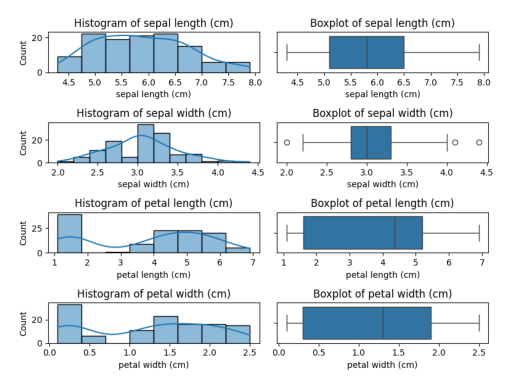

In [11]:
plt.imshow(plt.imread("figs/iris-20test-shuffled-v0_feature-statistics-X_train.png"))
plt.axis("off")
plt.show()

We have some outliers for sepal width. 

*Decision Trees are generally considered robust to outliers so we will leave them.*

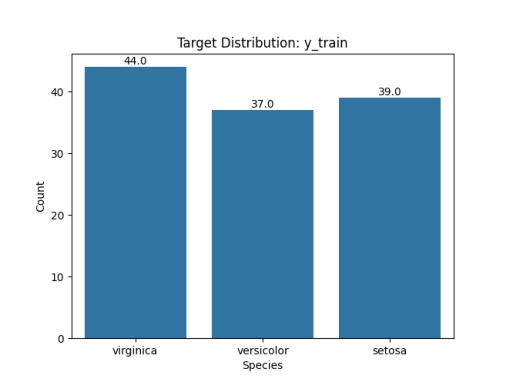

In [12]:
plt.imshow(plt.imread("figs/iris_target-class-distribution-y_train.png"))
plt.axis("off")
plt.show()

Classes in the train data are roughly balanced so we'll continue without any class balancing.

In [13]:
exp.update_param("n_train_samples", X_train.shape[0])
exp.update_param("n_test_samples", X_test.shape[0])
exp.summary_df

,dataset_name,n_train_samples,n_test_samples,mean_accuracy,train_time,query_time,kfolds,confusion_matrix,classification_report
exp_name,,,,,,,,,
dtc-iris-prepruned,iris-20test-shuffled-v1,120,30,NaN,NaN,NaN,NaN,NaN,NaN


## Inspect learning curve

- required data size: how much data is needed for get good performance before improvement plateau

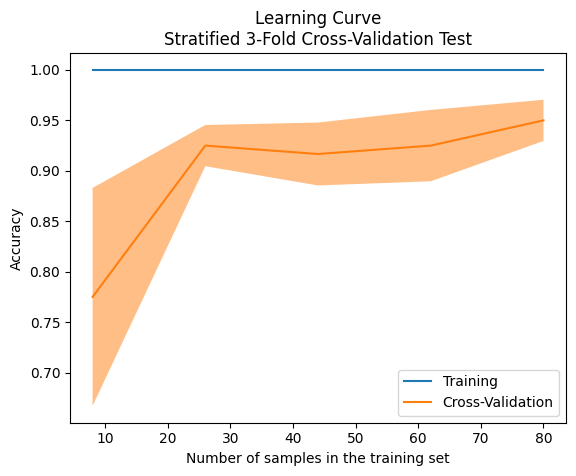

In [16]:
cv = StratifiedKFold(
    n_splits=3,
)
# Note: LearningCurveDisplay contains the scores as parameters (train_scores, test_scores)...could save these if needed
lcd = LearningCurveDisplay.from_estimator(
    estimator=exp.estimator,
    X=X_train,
    y=y_train,
    # train_sizes=np.linspace(0.1, 1.0, 5),
    # train_sizes=np.linspace(1, 80, 5).astype(int),
    train_sizes=np.linspace(0.1, 1.0, 5),
    # splitters are instantiated with shuffle=False so the splits will be the same across all calls
    cv=cv,
    random_state=0,
    # return_times = True, # default false
)

# Update the legend to change "Test" to "Cross-Validation"
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Training", "Cross-Validation"] if "Test" in labels else labels
plt.legend(handles, labels)

plt.title(f"Learning Curve\nStratified {cv.get_n_splits()}-Fold Cross-Validation Test")
plt.ylabel("Accuracy")
plt.savefig(f"{FIGS_DIR}/{exp.name}_learning-curve.png")

All of this is exactly the same as the unpruned DT so far.

In [37]:
exp.update_param("kfolds", f"Stratified {cv.get_n_splits()}-Fold Cross-Validation")

# Hyperparam search

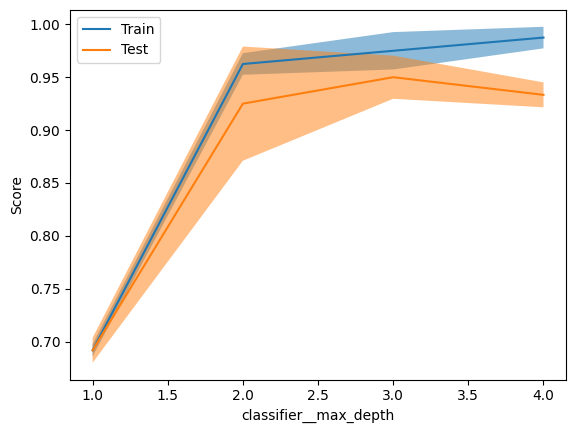

In [17]:
# figure out ranges for hyperparameters using validation curves
vcd_max_depth = ValidationCurveDisplay.from_estimator(
    estimator=exp.estimator,
    X=X_train,
    y=y_train,
    param_name="classifier__max_depth",
    param_range=np.arange(1, 5),
    cv=cv,
    # shuffle=True,
)

# Update the legend to change "Test" to "Cross-Validation"
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Training", "Cross-Validation"] if "Test" in labels else labels
plt.legend(handles, labels)

plt.title(
    f"Validation Curve\nStratified {cv.get_n_splits()}-Fold Cross-Validation Test"
)

plt.savefig(f"{FIGS_DIR}/{exp.name}_validation-curve-max-depth.png")

So, a max 2 or 3 seem okay. By eye, I'd go with 3 (we'll see what GridSearchCV says next but I'm guessing it will be 3).

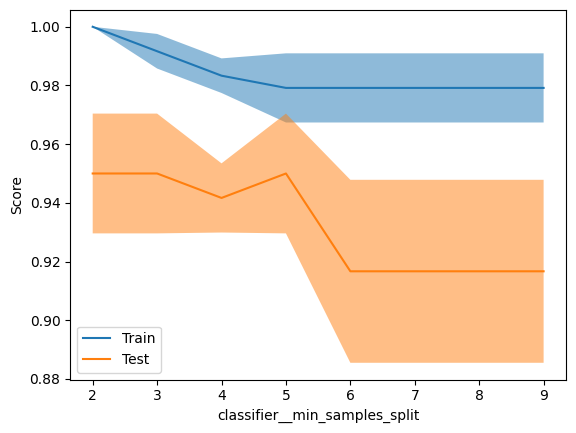

In [18]:
# figure out ranges for hyperparameters using validation curves
vcd_min_samples_split = ValidationCurveDisplay.from_estimator(
    estimator=exp.estimator,
    X=X_train,
    y=y_train,
    param_name="classifier__min_samples_split",
    param_range=np.arange(2, 10),
    cv=cv,
    # shuffle=True,
)

# Update the legend to change "Test" to "Cross-Validation"
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Training", "Cross-Validation"] if "Test" in labels else labels
plt.legend(handles, labels)

plt.title(
    f"Validation Curve\nStratified {cv.get_n_splits()}-Fold Cross-Validation Test"
)
plt.savefig(f"{FIGS_DIR}/{exp.name}_validation-curve-min-samples-split.png")

For min_samples_split, the validation curve looks like 2 gives a good accuracy score.

Now that we've seen the validation curves for these hyperparams, we have a good feel for the range that grid search should be looking in and what it will likely return.

Lets see if we're right

In [19]:
# set hyperparameters and train model (+report)
# perform and report experiments with different hyperparameters
param_grid = {
    "classifier__max_depth": np.arange(1, 4),
    "classifier__min_samples_split": np.arange(2, 5),
}

grid_search = GridSearchCV(
    estimator=exp.estimator,
    param_grid=param_grid,
    # scoring="", # accuracy is default but we can use another or many others
    cv=cv,
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(memory='.cache',
                                steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        DecisionTreeClassifier(criterion='entropy',
                                                               random_state=0))]),
             param_grid={'classifier__max_depth': array([1, 2, 3]),
                         'classifier__min_samples_split': array([2, 3, 4])})

In [20]:
grid_search.best_params_

{'classifier__max_depth': np.int64(3),
 'classifier__min_samples_split': np.int64(2)}

In [21]:
grid_search.best_score_

np.float64(0.9499999999999998)

GridSearch thinks 3 is the best max_depth and 2 is the best min_samples_split. Thats what we will go with for our prepruned model.

In [22]:
exp.estimator.set_params(**grid_search.best_params_)
exp.estimator.get_params()

{'memory': '.cache',
 'steps': [('scaler', StandardScaler()),
  ('classifier',
   DecisionTreeClassifier(criterion='entropy', max_depth=np.int64(3),
                          min_samples_split=np.int64(2), random_state=0))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': DecisionTreeClassifier(criterion='entropy', max_depth=np.int64(3),
                        min_samples_split=np.int64(2), random_state=0),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': np.int64(3),
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': np.int64(2),
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__monotonic_cst': None,
 'classifier__random_state': 0,
 'classifier__splitter': 'best'}

In [23]:
start_time = pd.Timestamp.now()
exp.estimator.fit(X_train, y_train)
train_time = pd.Timestamp.now() - start_time

In [24]:
exp.update_param("train_time", train_time)
exp.update_param(
    "mean_accuracy",
    exp.estimator.score(X_test, y_test),
    # add_column=True
)
exp.summary_df

,dataset_name,n_train_samples,n_test_samples,mean_accuracy,train_time,query_time,kfolds,confusion_matrix,classification_report
exp_name,,,,,,,,,
dtc-iris-prepruned,iris-20test-shuffled-v1,120,30,0.966667,0 days 00:00:00.003480,NaN,NaN,NaN,NaN


## Take a look at our prepruned trained model

In [25]:
text_representation = export_text(
    exp.estimator.named_steps["classifier"], feature_names=X_train.columns
)
print(text_representation)
with open(f"{RES_DIR}/{exp.name}-dtree.txt", "w") as f:
    f.write(text_representation)

|--- petal width (cm) <= -0.56
|   |--- class: 0
|--- petal width (cm) >  -0.56
|   |--- petal width (cm) <= 0.67
|   |   |--- petal length (cm) <= 0.64
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  0.64
|   |   |   |--- class: 2
|   |--- petal width (cm) >  0.67
|   |   |--- petal length (cm) <= 0.58
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  0.58
|   |   |   |--- class: 2



In [26]:
# convert target names series to list
target_names_list = target_names["target_names"].tolist()
target_names_list

['setosa', 'versicolor', 'virginica']

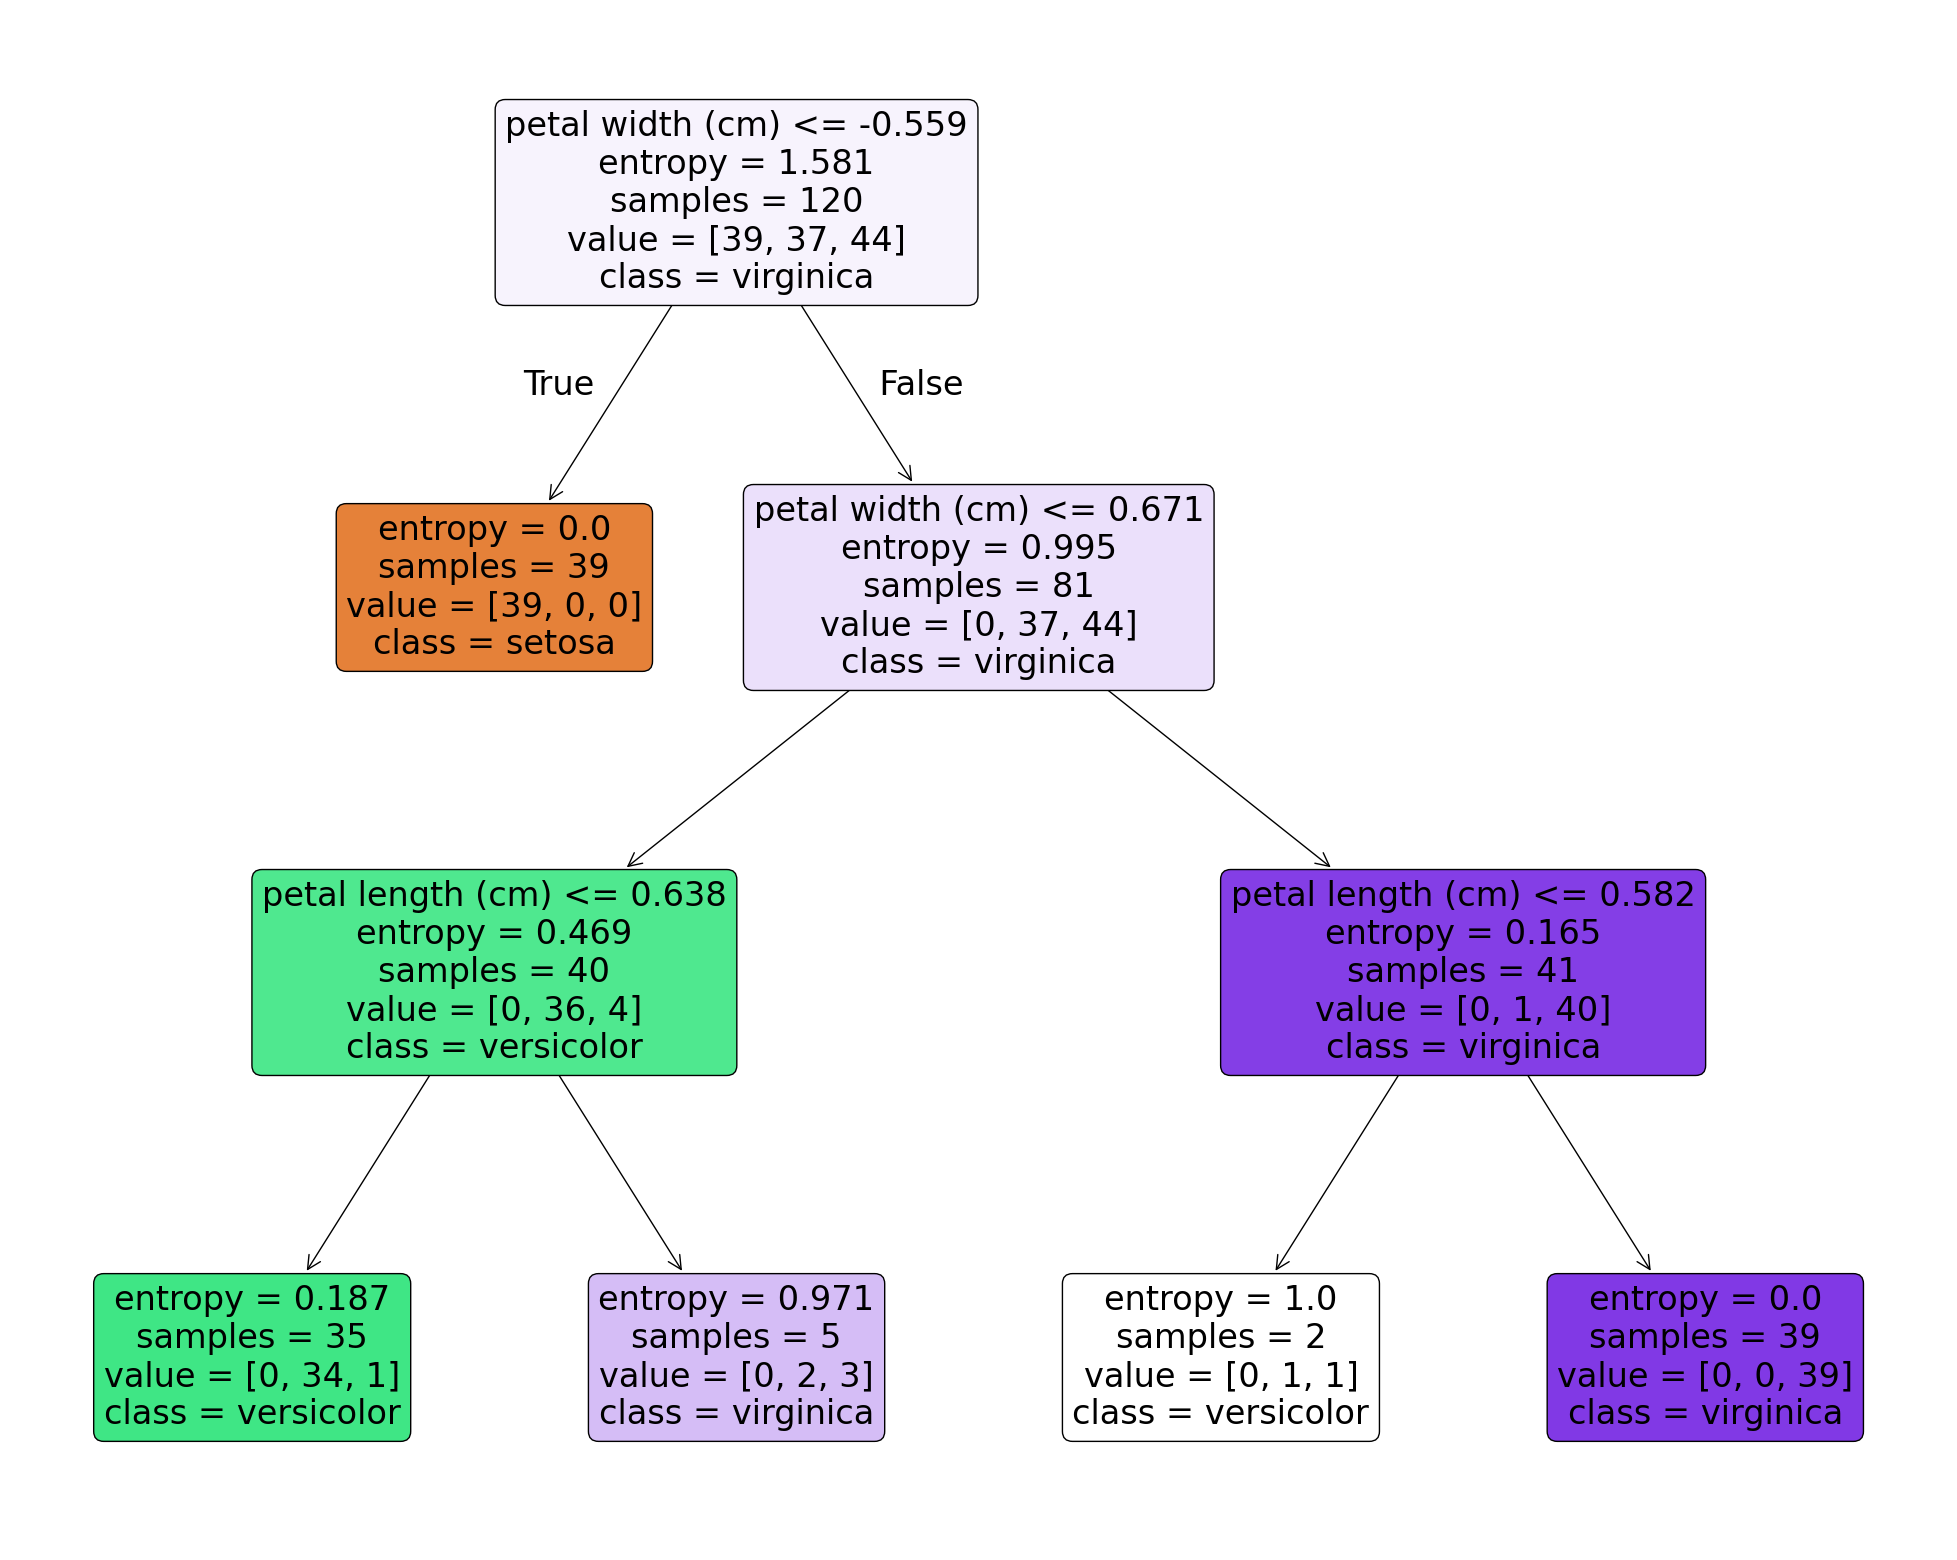

In [27]:
fig = plt.figure(figsize=(25, 20))
plot_tree(
    decision_tree=exp.estimator.named_steps["classifier"],
    feature_names=X_train.columns,
    class_names=target_names_list,
    filled=True,
    rounded=True,
)
plt.savefig(f"{FIGS_DIR}/{exp.name}_tree.png")

We can see its basically the same as the unpruned model but with a max_depth of 3.

In [28]:
# get precision, recall, f1, accuracy
start_time = pd.Timestamp.now()
y_pred = exp.estimator.predict(X_test)
query_time = pd.Timestamp.now() - start_time

In [34]:
exp.update_param("query_time", query_time)

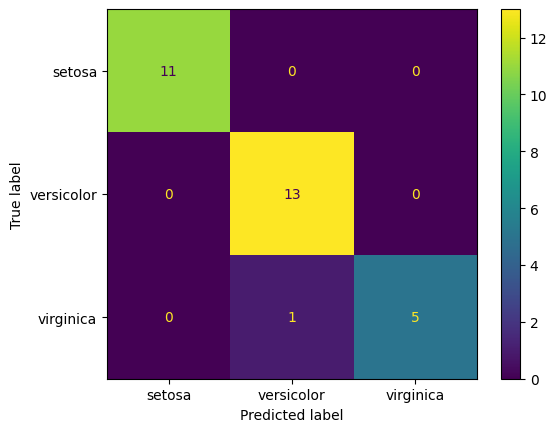

In [29]:
target_names_list = target_names["target_names"].tolist()
cm = confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    # normalize="true"
)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names_list)
cmd.plot()
plt.savefig(f"{FIGS_DIR}/{exp.name}_confusion-matrix.png")

It misses one but gets the rest right still.

In [30]:
exp.update_param("confusion_matrix", np.array2string(cm))

In [31]:
cr = classification_report(y_true=y_test, y_pred=y_pred, output_dict=True)
exp.update_param("classification_report", str(cr))
cr

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 11.0},
 '1': {'precision': 0.9285714285714286,
  'recall': 1.0,
  'f1-score': 0.9629629629629629,
  'support': 13.0},
 '2': {'precision': 1.0,
  'recall': 0.8333333333333334,
  'f1-score': 0.9090909090909091,
  'support': 6.0},
 'accuracy': 0.9666666666666667,
 'macro avg': {'precision': 0.9761904761904763,
  'recall': 0.9444444444444445,
  'f1-score': 0.957351290684624,
  'support': 30.0},
 'weighted avg': {'precision': 0.9690476190476189,
  'recall': 0.9666666666666667,
  'f1-score': 0.9657687991021324,
  'support': 30.0}}

In [32]:
# add custom decision tree classification specific metrics to the summary_df
exp.update_param(
    "split_criterion",
    exp.estimator.named_steps["classifier"].criterion,
    add_column=True,
)
exp.update_param(
    "tree_depth", exp.estimator.named_steps["classifier"].get_depth(), add_column=True
)
exp.update_param(
    "n_leaves", exp.estimator.named_steps["classifier"].get_n_leaves(), add_column=True
)
exp.update_param(
    "n_tree_nodes",
    exp.estimator.named_steps["classifier"].tree_.node_count,
    add_column=True,
)
exp.summary_df

Adding column: split_criterion
Adding column: tree_depth
Adding column: n_leaves


,dataset_name,n_train_samples,n_test_samples,mean_accuracy,train_time,query_time,kfolds,confusion_matrix,classification_report,split_criterion,tree_depth,n_leaves
exp_name,,,,,,,,,,,,
dtc-iris-prepruned,iris-20test-shuffled-v1,120,30,0.966667,0 days 00:00:00.003480,NaN,NaN,[[11 0 0]\n [ 0 13 0]\n [ 0 1 5]],"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",entropy,3,5


In [38]:
exp.save(overwrite_existing=False)

Loading 'classification-experiments.csv'
Overwriting existing experiment dtc-iris-prepruned
Saving experiment dtc-iris-prepruned to results/classification-experiments.csv
Dumping estimator dtc-iris-prepruned to .cache/dtc-iris-prepruned.joblib


## Conclusions

- Expectation: prepruning will generalize better than unpruned and learn faster
    + Yes, prepruned trained faster
    + I am not sure if you can say it generalized better....accuracy was a bit lower and it got one wrong but on the unpruned it got none wrong. I guess CV accuracy tells you about how well it generalizes which ...TODO...IDK
